# translation

In [1]:
import os
import shutil
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image

from dataset import TextDataset                          # custom module
from model.seq2seq import AttnDecoderRNN, DecoderRNN, EncoderRNN


use_cuda = torch.cuda.is_available()                     # gpu可用
# use_cuda = False
device = torch.device('cuda' if use_cuda else 'cpu')     # 优先使用gpu

## 1.读入数据，设置参数

In [2]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10
SOS_token = 0                                           # 词汇表中的起止符
EOS_token = 1

In [3]:
lang_dataset = TextDataset()

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['elle fait des progres en chinois .', 'she is progressing in chinese .']


In [4]:
lang_loader = DataLoader(lang_dataset, shuffle=True)   # use num_workers=4 can be slower???

In [5]:
%%time
for data in lang_loader:
    x, y = data
    print('source language:', x)
    print('target language:', y)
    break

source language: tensor([[   9, 1454, 1167,   42,    5,    1]])
target language: tensor([[  2,   3,  23, 691, 490,   4,   1]])
Wall time: 243 ms


### 注意数据集批次数据末尾的1表示`<EOS>`结束符，每个数据对都有

In [6]:
input_size = lang_dataset.input_lang_words
output_size = lang_dataset.output_lang_words
print('source language vocabulary size:', input_size)
print('target language vocabulary size:', output_size)

source language vocabulary size: 4489
target language vocabulary size: 2925


## 2. 训练模型

In [7]:
# Define hyperparameters
hidden_size = 128
epochs = 20
batch_size = 1
use_attn = False       # the sign whether to use attention

In [8]:
# define the model
encoder = EncoderRNN(vocab_size=input_size, hidden_size=hidden_size, n_layers=2)         # prefer using gpu
decoder = DecoderRNN(vocab_size=output_size, hidden_size=hidden_size, n_layers=2)
attn_decoder = AttnDecoderRNN(vocab_size=output_size, hidden_size=hidden_size, n_layers=2)

In [10]:
# train the translation model
import time
plot_losses = []
def train(encoder, decoder, epochs, use_attn):
    """
        func: train the seq2seq translation
        encoder: RNN encoding model
        decoder: RNN decoding model
        epochs: the number of iteration
        use_attn: whether to use attention, True represents use 
    """
    param = list(encoder.parameters()) + list(decoder.parameters())         # the parameters preparaed to optimize
    optimizer = optim.Adam(param, lr=1e-3)                                  # define the opimizer
    criterion = nn.NLLLoss()                                                # define the negative log likelihood loss
    for epoch in range(epochs):
        start = time.time()                                                 # calculate consumption time
        running_loss = 0                                                    # loss value during training
        total_loss = 0                                                      # total loss after training
        plt_loss_total = 0                                                  # loss value for plot
        print('{}epoch:{}{}'.format('-'*15, epoch+1, '-'*15))
        for i, data in enumerate(lang_loader):
            in_lang, out_lang = data
#             print(in_lang.shape, out_lang.shape)
            GPU = lambda x:x.to(device)                                     # prefer using gpu
            in_lang, out_lang = map(GPU, [in_lang, out_lang])               
            encoder, decoder = map(GPU, [encoder, decoder])
            
            # 1.encode source language to a context
            # encoder_outputs is used to attention decoder，该变量只用于注意力解码中
            encoder_outputs = torch.zeros([batch_size, MAX_LENGTH, hidden_size]).to(device)  # create a zero output
            encoder_hidden  = encoder.initHidden().to(device)               # initialize h0 state
            # in_lang:(N,seq)            
            for seq_idx in range(in_lang.shape[1]):
                encoder_output, encoder_hidden = encoder(in_lang[:, seq_idx:seq_idx+1], encoder_hidden)
                encoder_outputs[:,seq_idx:seq_idx+1] = encoder_output[:,:]           # [1, 1, hidden]
#                 print(encoder_outputs[:,seq_idx:seq_idx+1].shape,  encoder_output[:,:].shape)            
#             print(encoder_outputs.shape)                                 # (1,10,hidden)
            
            # 2.decode context to seqence
            decoder_input = torch.LongTensor([[SOS_token]]).to(device)     # note [[]] =>  get (1,1)
            decoder_hidden = encoder_hidden                                # (1,1,hidden) context tensor !!!
            loss = 0
            # 2.1 use attention to decode context
            if use_attn:
                for seq_idx in range(out_lang.shape[1]):
                    # decoder_output: (1,1,vocab_size) decoder_hidden: (1,1,hidden)
                    # decoder_attention: (1, 1, MAX_LENGTH)
                    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden,
                                                                                encoder_outputs)
                    
                    # predict: (1,1,vocab_size)  label:(1)
                    loss += criterion(decoder_output.view(1,-1), out_lang[:,seq_idx:seq_idx+1][0])
                    topv,topi = decoder_output.data.topk(1)
                    if topi[0][0] == EOS_token:
                        break
                    decoder_input = out_lang[:,seq_idx:seq_idx+1]      # (1,1)
            # 2.2 use no attention to decode context                    
            else:      
                for seq_idx in range(out_lang.shape[1]):
                    # decoder_output: (1,1,vocab_size) decoder_hidden: (1,1,hidden)
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                                        
                    # predict:(1,vocab_size)   label:(1)
                    loss += criterion(decoder_output.view(1,-1), out_lang[:,seq_idx:seq_idx+1][0])
                    topv, topi = decoder_output.data.topk(1)          # select the maximum value
                    if topi.item() == EOS_token:                      # finish decoding
                        break
                    # teacher forcing指在训练过程中直接使用正确的标签来进行解码器的训练，当然可以取当前时刻输出的
                    # 最大值作为下一个时刻的输入，但teacher forcing可以加速收敛，但在测试时下一个时刻的输入必须是当前
                    # 时刻输出的值(输出字典大小的向量，取最大的值对应的索引当做输出的词)
                    decoder_input = out_lang[:,seq_idx:seq_idx+1]   # use teacher forcing to accelerate convergence!!!
                    
            optimizer.zero_grad()           # clear the gradient
            loss.backward()                 # backpropagation
            optimizer.step()                # update the parameters
            running_loss += loss.item()
            plt_loss_total += loss.item()
            total_loss += loss.item()
            if (i + 1) % 500 == 0:
                print('{}/{}, Loss:{:.6f}'.format(i+1, len(lang_loader), running_loss/500))
                running_loss = 0
            if (i + 1) % 100 == 0:
                plot_loss = plt_loss_total / 100
                plot_losses.append(plot_loss)
                plt_loss_total = 0

        epoch_time = time.time() - start                            # calculate consumption time
        print('Finish {}/{}, Loss:{:.6f}, Time:{:.0f}s'.format(epoch+1, epochs, 
                                                               total_loss/len(lang_loader), epoch_time))
    # save the model
    attn = 'attn_' if use_attn else ''
    torch.save(encoder.state_dict(), os.path.join('snapshot', 'encoder.pth'))
    torch.save(decoder.state_dict(), os.path.join('snapshot', attn+'decoder.pth'))

train(encoder, decoder, 1, use_attn=False)
# train(encoder, attn_decoder, 2, use_attn=True)

---------------epoch:1---------------
500/10853, Loss:21.422131
1000/10853, Loss:20.050512
1500/10853, Loss:19.707606
2000/10853, Loss:18.458258
2500/10853, Loss:17.537111
3000/10853, Loss:17.721788
3500/10853, Loss:17.243726
4000/10853, Loss:16.622123
4500/10853, Loss:17.600505
5000/10853, Loss:16.238710
5500/10853, Loss:15.749693
6000/10853, Loss:15.687889
6500/10853, Loss:15.487883
7000/10853, Loss:15.547331
7500/10853, Loss:14.931321
8000/10853, Loss:15.572950
8500/10853, Loss:15.032901
9000/10853, Loss:15.266654
9500/10853, Loss:15.104083
10000/10853, Loss:15.196235
10500/10853, Loss:13.543949
Finish 1/1, Loss:16.569376, Time:656s


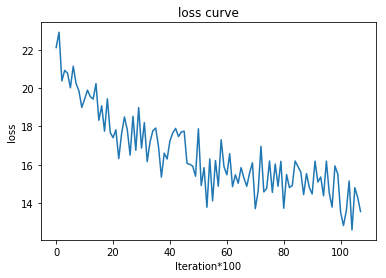

In [11]:
plt.title('loss curve')
plt.xlabel('Iteration*100')
plt.ylabel('loss')
plt.plot(plot_losses)       # batch_size = 1, so there is a big jitter

## 3. 评估模型
注意在训练中使用了teacher forcing，即直接将标签输入解码器，但测试时输入只能根据上时刻的输出来得出，一般取最大值对应的索引来表示输入的词的one-hot

In [12]:
batch_size = 1
hidden_size = 128
input_size = lang_dataset.input_lang_words
output_size = lang_dataset.output_lang_words

In [13]:
eval_encoder = EncoderRNN(vocab_size=input_size, hidden_size=hidden_size, n_layers=2)         # prefer using gpu
eval_decoder = DecoderRNN(vocab_size=output_size, hidden_size=hidden_size, n_layers=2)
eval_attn_decoder = AttnDecoderRNN(vocab_size=output_size, hidden_size=hidden_size, n_layers=2)

In [14]:
# load encoder and decoder's weight
encoder_path = os.path.join('snapshot', 'encoder.pth')
decoder_path = os.path.join('snapshot', 'decoder.pth')
attndecoder_path = os.path.join('snapshot', 'attn_decoder.pth')
eval_encoder.load_state_dict(torch.load(encoder_path))
eval_decoder.load_state_dict(torch.load(decoder_path))
eval_attn_decoder.load_state_dict(torch.load(attndecoder_path))

In [18]:
# define evaluate function
def evaluate(encoder, decoder, in_lang, use_attn, max_length=MAX_LENGTH):
    """
        func: evaluate the seq2seq model
        encoder: the RNN encoder
        decoder: the RNN decoder
        in_lang: input language data(Tensor) dims: (N,seq)
        max_length: the maximum length of the sequence
    """
    seq_length = in_lang.shape[1]                              # get the length of the input language sequence
    eval_mode = lambda x:x.eval().cpu()
    encoder, decoder = map(eval_mode, [encoder, decoder])      # change the model to evaluation model and use CPU
    
    # 1.encode the input tensor into context
    encoder_outputs = torch.zeros([batch_size, max_length, hidden_size])   # for attention!!! (N,max_l,hidden)
#     print(encoder_outputs.shape)
    encoder_hidden = encoder.initHidden()                                       # (1, N, hidden)
    for seq_idx in range(seq_length):
        encoder_ouput, encoder_hidden = encoder(in_lang[:,seq_idx:seq_idx+1], encoder_hidden)
        # => encoder_output:(N,seq,hidden),seq=1  encoder_hidden:(1,N,hidden)
#         print(encoder_ouput.shape, encoder_hidden.shape)
#         print(encoder_outputs.shape, encoder_ouput[:,:].shape)
        encoder_outputs[:,seq_idx:seq_idx+1] = encoder_ouput[:,:]             # [N, 1, hidden]
       
    # 2.decode the context into sequence
    decoder_input = torch.LongTensor([[SOS_token]])                             # (N,1)
    decoder_hidden = encoder_hidden                                             # context (N,1,hidden)
    decoded_words = []                                                          # store the generated words
    decoder_attentions = torch.zeros([batch_size, max_length, max_length])      # store the attention
    # 2.1 use attention to decode 
    if use_attn:
        for seq_idx in range(max_length):
            decoder_output, decoder_hidden, attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # => decoder_output:(N,1,vocab_size)  decoder_hidden:(1,N,hidden)  attention:(N,1,max_length)
            decoder_attentions[:,seq_idx:seq_idx+1] = attention.data
            topv, topi = decoder_output.data.topk(1)                           # select the maximum value along the last dim
            # => topi: (N,1,1) 
            max_index = topi[0][0]    # (1)
            if max_index == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang_dataset.output_lang.index2word[max_index.item()])  # return the word
                
            # max_index with respect to the input in the next step
            decoder_input = torch.LongTensor([[max_index]])                    # get (1,1)
    else:
        for seq_idx in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # => decoder_output:(N,1,vocab_size)   decoder_hidden:(1,N,hidden)
            topv, topi = decoder_output.data.topk(1)                            # (N,1,1)
            max_index = topi[0][0]                                             # (1,)
            if max_index == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang_dataset.output_lang.index2word[max_index.item()])
            
            # put prediction to the next input
            decoder_input = torch.LongTensor([[max_index]])
    if use_attn:
        return decoded_words, decoder_attentions[:, :seq_idx+1]
    else:
        return decoded_words

In [20]:
import random
def test(encoder,decoder,n=10, use_attn=True):
    for i in range(10):
        sample_index = random.choice(range(len(lang_dataset)))       # randomly pick a index
        sample_pair = lang_dataset.pairs[sample_index]               # get the string pair w.r.t index
        in_lang, out_lang = lang_dataset[sample_index]               # get the tensor of the pairs     
        in_lang, out_lang = map(lambda x:x.unsqueeze(0), [in_lang, out_lang])   # get (N,seq)
#         print(in_lang.shape, out_lang.shape)
        if use_attn:
            output_words, decoder_attentions = evaluate(encoder, decoder, in_lang, use_attn=True)
        else:
            output_words = evaluate(encoder, decoder, in_lang, use_attn=False)
        output_sentence = ' '.join(output_words)
        print('-'*50)
        print('source: ', sample_pair[0])
        print('target: ', sample_pair[1])
        print('translation: ', output_sentence)
test(eval_encoder, eval_attn_decoder)
# test(eval_encoder, eval_decoder, use_attn=False)

--------------------------------------------------
source:  je suis l elue .
target:  i am the chosen one .
translation:  you . <EOS>
--------------------------------------------------
source:  vous etes minces .
target:  you re thin .
translation:  they re tired . <EOS>
--------------------------------------------------
source:  il est le president du comite .
target:  he s the chairman of the committee .
translation:  you . <EOS>
--------------------------------------------------
source:  tu n es pas chanteuse .
target:  you re no singer .
translation:  they re nuts . <EOS>
--------------------------------------------------
source:  je me rejouis de vous contenter .
target:  i m glad i make you happy .
translation:  . <EOS>
--------------------------------------------------
source:  il est tres protecteur .
target:  he s very protective .
translation:  you . <EOS>
--------------------------------------------------
source:  nous ne sommes pas encore morts .
target:  we re not dead yet

注意

1. CrossEntropyLoss及NLLLoss的标签都是1维度的，否则会报错
2. decoder_output.data.topk(top_num)默认是沿着最后一维，也可以使用dim=2来指定特定的维度